### Visualizing the distribution of the observations

### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSBSSSBB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
13081
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|    14|[90 55 A0 56 38 5...|1946.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|     0|[B0 58 E0 55 B0 5...|1947.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|     1|[78 5B 98 5A A0 5...|1948.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|    32|[70 5A 98 5A 48 5...|1950.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       TMAX|USC00095386|     7|[00 58 90 59 C8 5...|1951.0|BSBSSSBB|
+---------+--------+---------+-----------+-----------+------+-------------

In [157]:
df.filter(df.measurement=='TMAX').rdd.map(lambda row: unpackArray(row['vector'],np.float16)).collect()

[array([  89.,  106.,  167.,  211.,  211.,  244.,  261.,  256.,  206.,
         217.,  239.,  211.,  167.,  122.,  117.,   78.,  100.,  161.,
         156.,  106.,  122.,  111.,   89.,  128.,  144.,  183.,  172.,
         144.,  139.,  250.,  200.,  139.,  167.,  183.,  228.,  233.,
         200.,  161.,  206.,  233.,  222.,  161.,  183.,  250.,  217.,
         144.,  150.,  200.,  228.,  206.,  167.,  172.,  217.,  228.,
         189.,  194.,  228.,  222.,  178.,   nan,   nan,   nan,   nan,
          nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
          nan,  272.,  233.,  222.,  261.,  206.,  128.,  261.,  261.,
         278.,  278.,  278.,  272.,  244.,  239.,  289.,  222.,  233.,
         233.,  272.,  294.,  317.,  306.,  278.,  294.,  311.,  306.,
         306.,  300.,  261.,  189.,  206.,  222.,  278.,  289.,  211.,
         239.,  289.,  300.,  317.,  283.,  311.,  311.,  239.,  233.,
         217.,  250.,  294.,  306.,  278.,  283.,  278.,  256.,  306.,
      

In [110]:
c = df.select('latitude','longitude').distinct().rdd.map(lambda x:[x[0],x[1]]).collect()
lat = np.array(c)[:,0]
lon = np.array(c)[:,1]

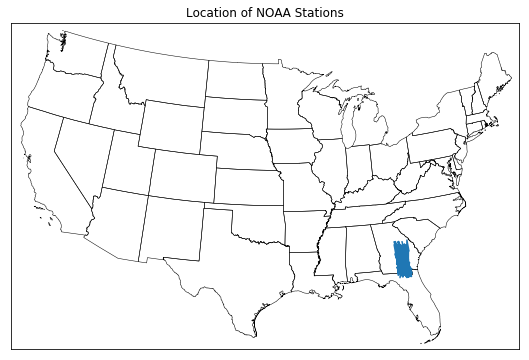

In [123]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

plt.figure(figsize=(12,6))
m = Basemap(llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49,
        projection='lcc',lat_1=32,lat_2=45,lon_0=-95,resolution='i')
m.readshapefile('st99_d00', name='states', drawbounds=True)
x,y = m(lon,lat)
m.plot(x,y,markersize=0.1)
plt.title('Location of NOAA Stations')
plt.show()

In [126]:
df.describe('year').show()

+-------+------------------+
|summary|              year|
+-------+------------------+
|  count|             13081|
|   mean|1970.5463649568076|
| stddev| 28.02272468189662|
|    min|            1893.0|
|    max|            2012.0|
+-------+------------------+



### Select data for a particular station and measurement type

In [114]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' --and station='%s'"%('PRCP','USC00095386')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' --and station='USC00095386'
2833 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     36.6| 31.9297| -82.6792|       PRCP|USC00095386|     0|[00 00 00 00 00 0...|1910.0|BSBSSSBB|
|     36.6| 31.9297| -82.6792|       PRCP|USC00095386|     2|[00 45 00 00 10 5...|1911.0|BSBSSSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(2833, 365)

In [154]:
rows[0]

array([   0.,    0.,    0.,    0.,    0.,    0.,   20.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          5.,    0.,  147.,    0.,    0.,   46.,    0.,    0.,    0.,
          0.,  411.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,   15.,    5.,   56.,  193.,    0.,    0.,
          0.,    0.,    0.,  284.,    0.,    0.,    3.,   15.,   61.,
        142.,   76.,    0.,    0.,    0.,  213.,  284.,   81.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,   56.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,  117.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,  117.,   10.,    0.,    0.,   61.,  142.,
          0.,    0.,   15.,    0.,    0.,   51.,    0.,    0.,   20.,
         66.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,

### Script for plotting yearly plots

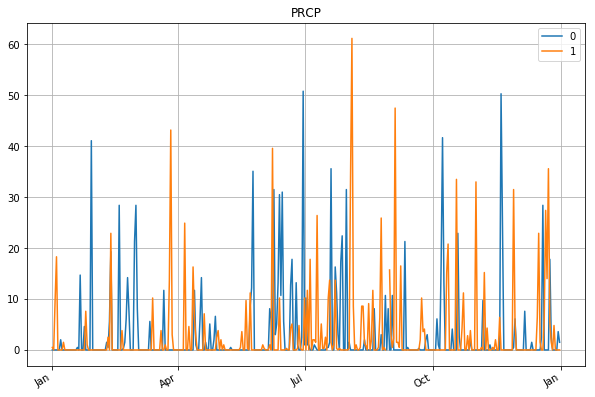

In [129]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [130]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)
    

/Users/Alison/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


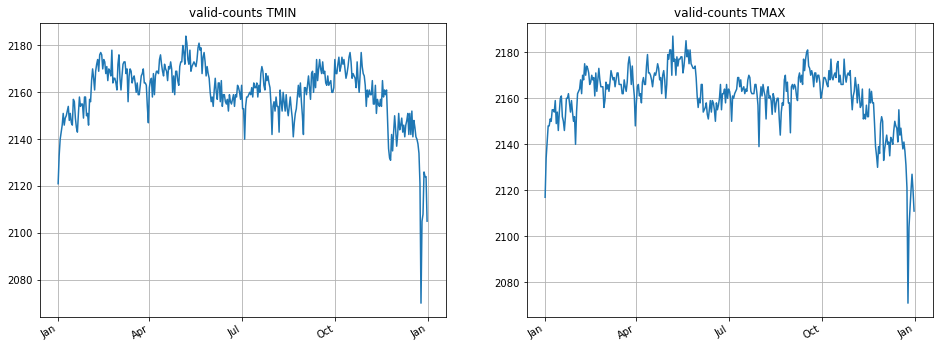

In [131]:
plot_pair(['TMIN','TMAX'],plot_valid)

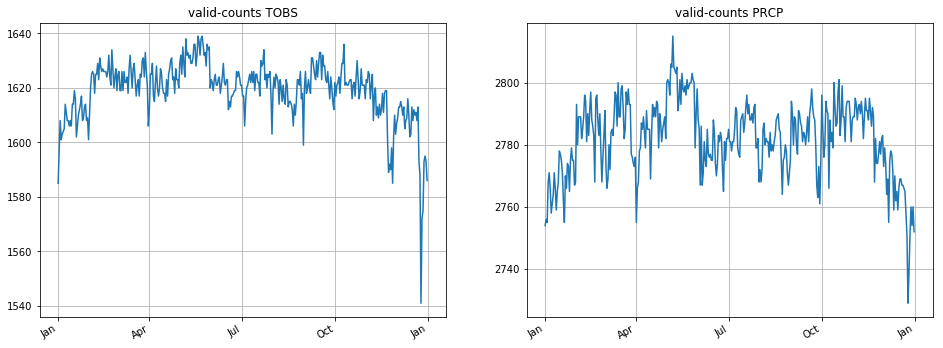

In [132]:
plot_pair(['TOBS','PRCP'],plot_valid)

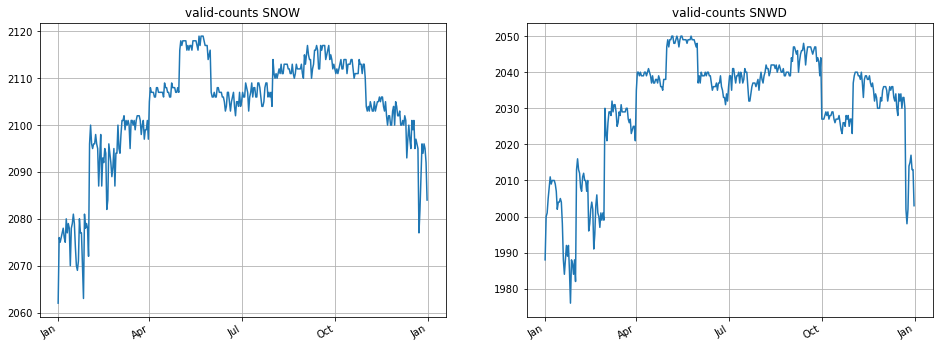

In [133]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [169]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m,labels=['mean-std','mean','mean+std'])

In [166]:
def plot_mean_std_temp(m,fig,axis):
    mean=STAT[m]['Mean']/10.0
    std=np.sqrt(STAT[m]['Var'])/10.0
    graphs=np.vstack([mean-std,mean,mean+std]).transpose()
    YP.plot(graphs,fig,axis,title='Mean+-std   '+m,labels=['mean-std','mean','mean+std'])

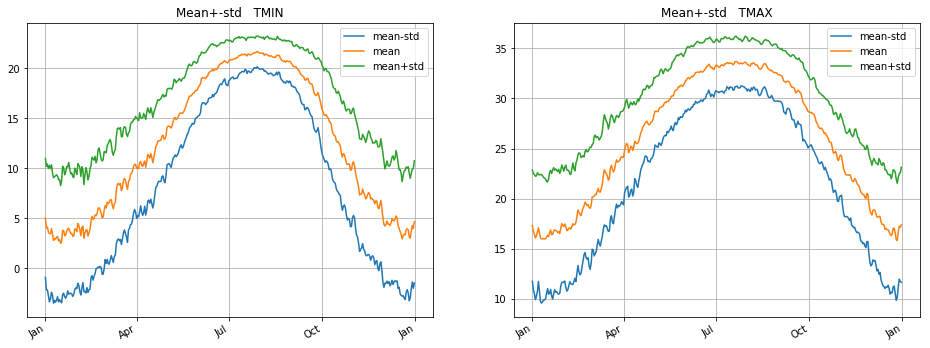

In [167]:
plot_pair(['TMIN','TMAX'],plot_mean_std_temp)

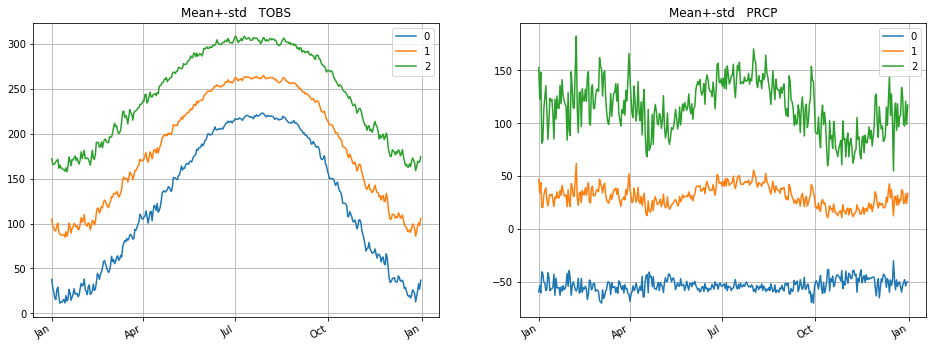

In [16]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

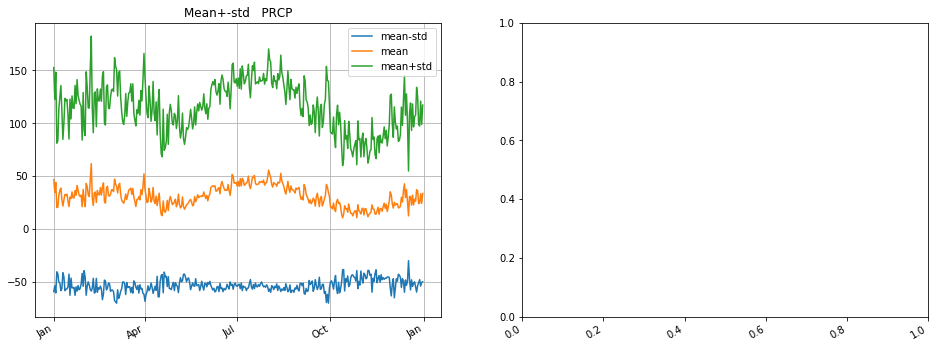

In [170]:
plot_pair(['PRCP'],plot_mean_std)

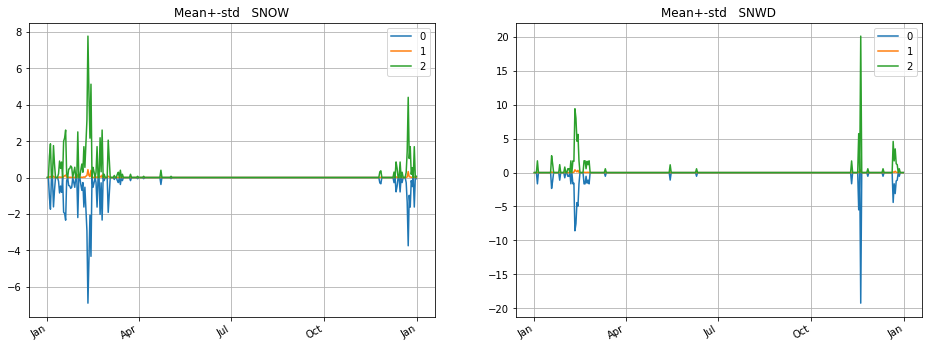

In [17]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [18]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:3],fig,axis,title='Top Eigenvectors '+m)

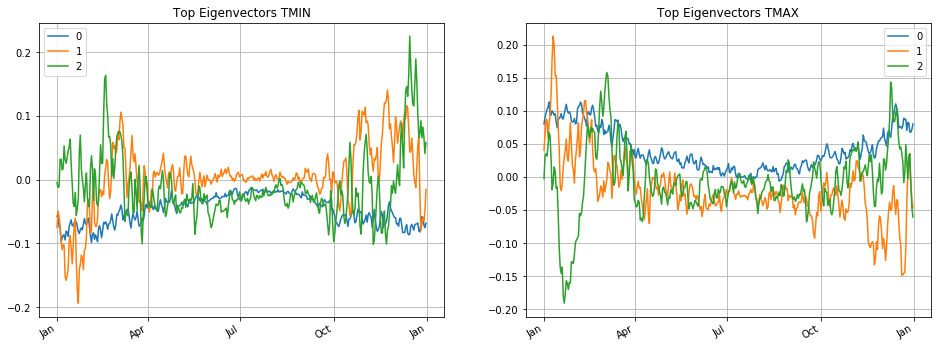

In [19]:
plot_pair(['TMIN','TMAX'],plot_eigen)

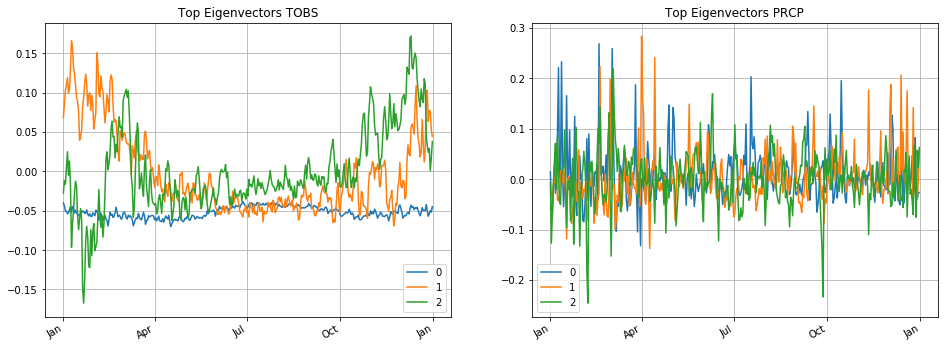

In [20]:
plot_pair(['TOBS','PRCP'],plot_eigen)

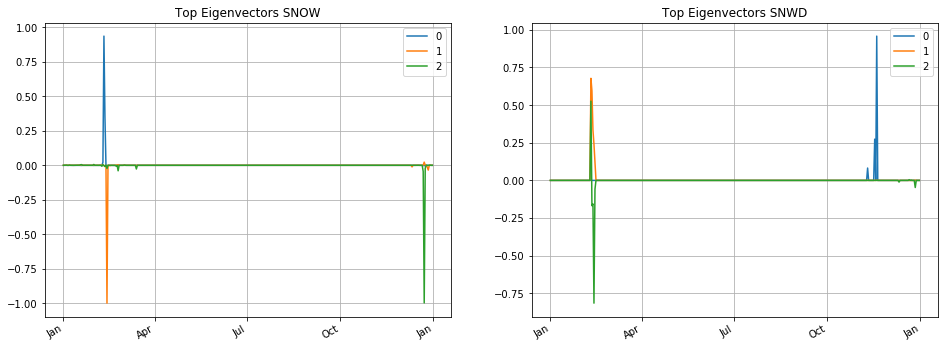

In [21]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [172]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=5
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

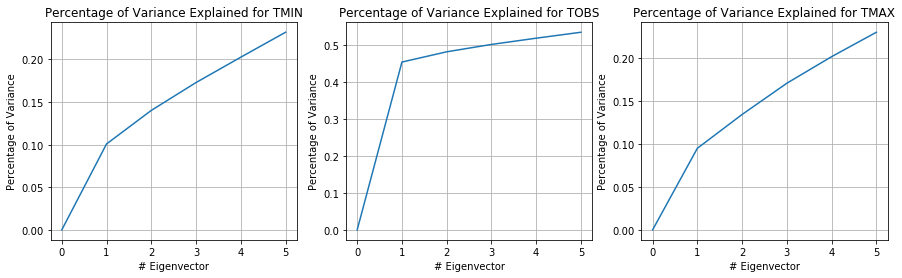

In [173]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

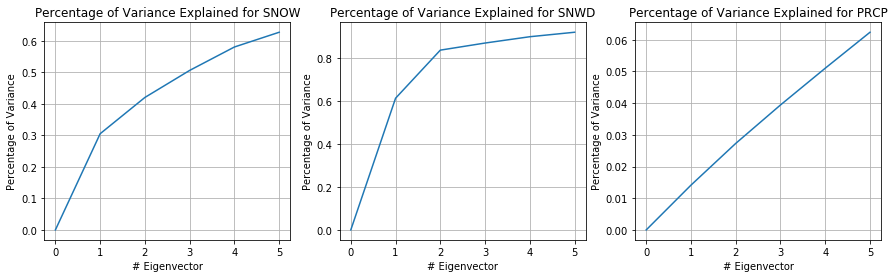

In [175]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [25]:
#sc.stop()